<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>

# 4a. Data Augmentation

So far, we've selected a model architecture that vastly improves the model's performance, as it is designed to recognize important features in the images. The validation accuracy is still lagging behind the training accuracy, which is a sign of overfitting: the model is getting confused by things it has not seen before when it tests against the validation dataset.

In order to teach our model to be more robust when looking at new data, we're going to programmatically increase the size and variance in our dataset. This is known as [*data augmentation*](https://link.springer.com/article/10.1186/s40537-019-0197-0), a useful technique for many deep learning applications.

The increase in size gives the model more images to learn from while training. The increase in variance helps the model ignore unimportant features and select only the features that are truly important in classification, allowing it to generalize better.

## 4a.1 Objectives

* Augment the ASL dataset
* Use the augmented data to train an improved model
* Save the well-trained model to disk for use in deployment

In [1]:
import torch.nn as nn
import pandas as pd
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt

import utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

## 4a.2 Preparing the Data

As we're in a new notebook, we will load and process our data again. To do this, execute the following cell:

In [2]:
IMG_HEIGHT = 28
IMG_WIDTH = 28
IMG_CHS = 1
N_CLASSES = 24

train_df = pd.read_csv("data/asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv("data/asl_data/sign_mnist_valid.csv")

class MyDataset(Dataset):
    def __init__(self, base_df):
        x_df = base_df.copy()
        y_df = x_df.pop('label')
        x_df = x_df.values / 255  # Normalize values from 0 to 1
        x_df = x_df.reshape(-1, IMG_CHS, IMG_WIDTH, IMG_HEIGHT)
        self.xs = torch.tensor(x_df).float().to(device)
        self.ys = torch.tensor(y_df).to(device)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x, y

    def __len__(self):
        return len(self.xs)

n = 32
train_data = MyDataset(train_df)
train_loader = DataLoader(train_data, batch_size=n, shuffle=True)
train_N = len(train_loader.dataset)

valid_data = MyDataset(valid_df)
valid_loader = DataLoader(valid_data, batch_size=n)
valid_N = len(valid_loader.dataset)

## 4a.3 Model Creation

We will also need to create our model again. As we learned in the last lesson, convolutional neural networks use a repeated sequence of layers. Let's take advantage of this pattern to make our own [custom module](https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html). We can then use this module like a layer in our [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) model.

To do this, we will extend the [Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) class. Then we will define two methods:
* `__init__`: defines any properties we want our module to have, including our neural network layers. We will effectively be using a model within a model.
* `forward`: defines how we want the module to process any incoming data from the previous layer it is connected to. Since we are using a `Sequential` model, we can pass the input data into it like we are making a prediction.

In [3]:
class MyConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_p):
        kernel_size = 3
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.MaxPool2d(2, stride=2)
        )

    def forward(self, x):
        return self.model(x)

Now that we've define our custom module, let's see it in action. The below model ia archecturially the same as in the previous lesson. Can you see the connection?

In [4]:
flattened_img_size = 75 * 3 * 3

# Input 1 x 28 x 28
base_model = nn.Sequential(
    MyConvBlock(IMG_CHS, 25, 0), # 25 x 14 x 14
    MyConvBlock(25, 50, 0.2), # 50 x 7 x 7
    MyConvBlock(50, 75, 0),  # 75 x 3 x 3
    # Flatten to Dense Layers
    nn.Flatten(),
    nn.Linear(flattened_img_size, 512),
    nn.Dropout(.3),
    nn.ReLU(),
    nn.Linear(512, N_CLASSES)
)

When we print the model, not only will it now show the use of our custom module, it will also show the layers within our custom module:

In [5]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(base_model.parameters())

model = torch.compile(base_model.to(device))
model

OptimizedModule(
  (_orig_mod): Sequential(
    (0): MyConvBlock(
      (model): Sequential(
        (0): Conv2d(1, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0, inplace=False)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): MyConvBlock(
      (model): Sequential(
        (0): Conv2d(25, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): MyConvBlock(
      (model): Sequential(
        (0): Conv2d(50, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(75, eps=1e-05, momentum=0.1, affin

Custom modules are flexible, and we can define any other methods or properties we wish to have. This makes them powerful when data scientists are trying to solve complex problems.

## 4a.4 Data Augmentation

Before defining our training loop, it's time to set up our data augmentation.

We've seen [TorchVision](https://pytorch.org/vision/stable/index.html)'s [Transforms](https://pytorch.org/vision/0.9/transforms.html) before, but in this lesson, we will further explore its data augmentation tools. First, let's get a sample image to test with:

In [6]:
row_0 = train_df.head(1)
y_0 = row_0.pop('label')
x_0 = row_0.values / 255
x_0 = x_0.reshape(IMG_CHS, IMG_WIDTH, IMG_HEIGHT)
x_0 = torch.tensor(x_0)
x_0.shape

torch.Size([1, 28, 28])

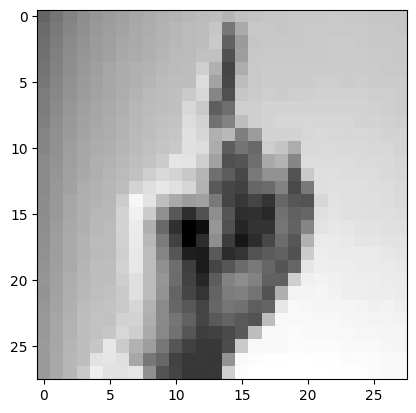

In [7]:
image = F.to_pil_image(x_0)
plt.imshow(image, cmap='gray')

### 4a.4.1 [RandomResizeCrop](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomResizedCrop)

This transform will randomly resize the input image based on `scale`, and then [crop](https://en.wikipedia.org/wiki/Cropping_(image)) it to a size we specify. In this case, we will crop it to the original image dimensions. To do this, TorchVision needs to know the [aspect ratio](https://en.wikipedia.org/wiki/Aspect_ratio_(image)) of the image it is scaling. Since our height is the same as our width, our aspect `ratio` is 1:1.

In [8]:
trans = transforms.Compose([
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.7, 1), ratio=(1, 1)),
])

Try running the below cell a few times. It should be different each time.

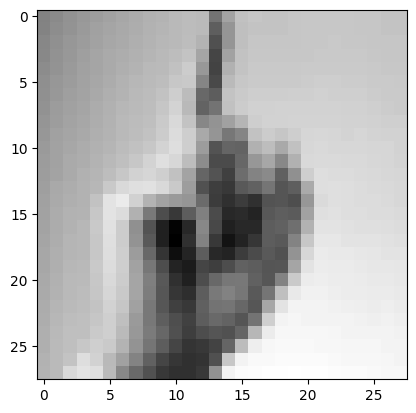

In [9]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

In [10]:
new_x_0.shape

torch.Size([1, 28, 28])

### 4a.4.2 [RandomHorizontalFlip](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomHorizontalFlip)

We can also randomly flip our images [Horizontally](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomHorizontalFlip) or [Vertically](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomVerticalFlip). However, for these images, we will only flip them horizontally.

Take a moment to think about why we would want to flip images horizontally, but not vertically. When you have an idea, reveal the text below.

`# SOLUTION` Fun fact: American Sign Language can be done with either the left or right hand being dominant. However, it is unlikely to see sign language from upside down. This kind of domain-specific reasoning can help make good decisions for your own deep learning applications.

In [11]:
trans = transforms.Compose([
    transforms.RandomHorizontalFlip()
])

Try running the below cell a few times. Does the image flip about half the time?

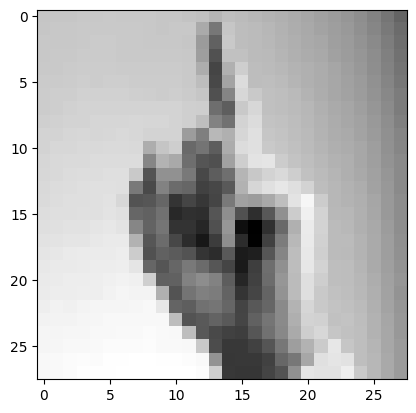

In [12]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

### 4a.4.3 [RandomRotation](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.RandomRotation)

We can also randomly rotate the image to add more variability. Just like with with other augmentation techniques, it's easy to accidentally go too far. With ASL, if we rotate too much, our `D`s might look like `G`s and visa versa. Because of this, let's limit it to `30` degrees.

In [13]:
trans = transforms.Compose([
    transforms.RandomRotation(10)
])

When we run the cell block below, some black pixels may appear. The corners or our image disappear when we rotate, and for almost every pixel we lose, we gain an empty pixel.

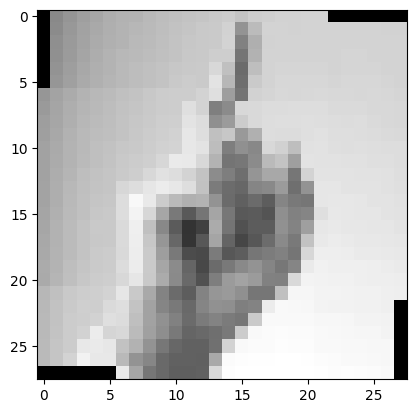

In [14]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

### 4a.4.3 [ColorJitter](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.ColorJitter)

The `ColorJitter` transform has 4 arguments:
* [brightness](https://en.wikipedia.org/wiki/Brightness)
* [contrast](https://en.wikipedia.org/wiki/Contrast_(vision))
* [saturation](https://en.wikipedia.org/wiki/Colorfulness#Saturation)
* [hue](https://en.wikipedia.org/wiki/Hue)


The latter 2 apply to color images, so we will only use the first 2 for now.

In [15]:
brightness = .2  # Change to be from 0 to 1
contrast = .5  # Change to be from 0 to 1

trans = transforms.Compose([
    transforms.ColorJitter(brightness=brightness, contrast=contrast)
])

Try running the below a few times, but also try changing either `brightness` or `contrast` to `1`. Get any intersting results?

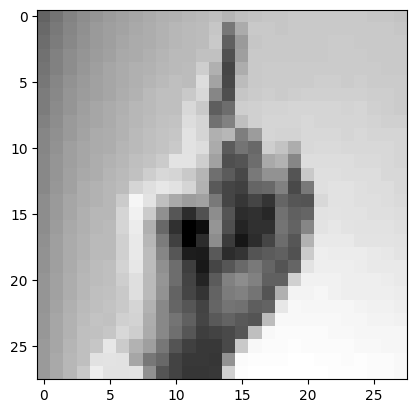

In [16]:
new_x_0 = trans(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

### 4a.3.4 [Compose](https://pytorch.org/vision/0.9/transforms.html#torchvision.transforms.Compose)

Time to bring it all together. We can create a sequence of these random transformations with `Compose`.

In [17]:
random_transforms = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomResizedCrop((IMG_WIDTH, IMG_HEIGHT), scale=(.9, 1), ratio=(1, 1)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=.2, contrast=.5)
])

Let's test it out. With all the different combinations how many varations are there of this one image? Infinite?

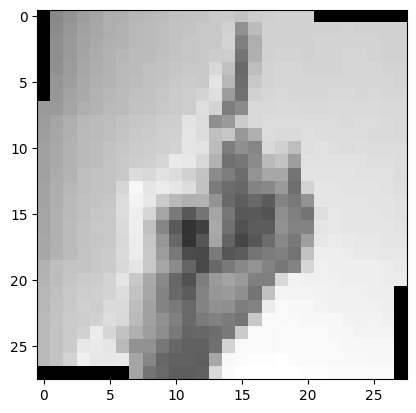

In [18]:
new_x_0 = random_transforms(x_0)
image = F.to_pil_image(new_x_0)
plt.imshow(image, cmap='gray')

### 4a.4 Training with Augmentation

Our training is mostly the same, but there is one line of change. Before passing our images to our model, we will apply our `random_transforms`. For conveneince, we moved `get_batch_accuracy` to a [utils](./utils.py) file.

In [19]:
def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = model(random_transforms(x))  # Updated
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += utils.get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

On the other hamd, validation remains the same. There are no random transformations. 

In [20]:
def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += utils.get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

Let's put data augmentation to the test. 

In [21]:
epochs = 20

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()

Epoch: 0
Train - Loss: 600.6782 Accuracy: 0.7748
Valid - Loss: 50.1873 Accuracy: 0.9241
Epoch: 1
Train - Loss: 104.7192 Accuracy: 0.9606
Valid - Loss: 15.3473 Accuracy: 0.9788
Epoch: 2
Train - Loss: 55.2596 Accuracy: 0.9795
Valid - Loss: 26.9417 Accuracy: 0.9688
Epoch: 3
Train - Loss: 39.4462 Accuracy: 0.9844
Valid - Loss: 13.1709 Accuracy: 0.9801
Epoch: 4
Train - Loss: 38.4098 Accuracy: 0.9850
Valid - Loss: 15.4153 Accuracy: 0.9745
Epoch: 5
Train - Loss: 29.6552 Accuracy: 0.9889
Valid - Loss: 41.0254 Accuracy: 0.9495
Epoch: 6
Train - Loss: 21.8263 Accuracy: 0.9915
Valid - Loss: 17.6020 Accuracy: 0.9721
Epoch: 7
Train - Loss: 25.3136 Accuracy: 0.9899
Valid - Loss: 14.4394 Accuracy: 0.9746
Epoch: 8
Train - Loss: 19.6554 Accuracy: 0.9932
Valid - Loss: 9.0259 Accuracy: 0.9914
Epoch: 9
Train - Loss: 22.4088 Accuracy: 0.9911
Valid - Loss: 19.3118 Accuracy: 0.9799
Epoch: 10
Train - Loss: 15.4399 Accuracy: 0.9939
Valid - Loss: 24.4199 Accuracy: 0.9738
Epoch: 11
Train - Loss: 17.3803 Accuracy:

## Discussion of Results

You will notice that the validation accuracy is higher, and more consistent. This means that our model is no longer overfitting in the way it was; it generalizes better, making better predictions on new data.

The training accuracy may be lower, and that's ok. Compared to before, the model is being exposed to a much larger variety of data.

## Saving the Model

Now that we have a well-trained model, we will want to deploy it to perform inference on new images.

It is common, once we have a trained model that we are happy with to save it to disk. PyTorch has [multiple ways](https://pytorch.org/tutorials/beginner/saving_loading_models.html) to do this, but for now, we will use `torch.save`. We will also need to save the code for our `MyConvBlock` custom module, which we did in [utils.py](./utils.py). In the next notebook, we'll load the model and use it to read new sign language pictures.

PyTorch cannot save a compiled model ([see this post](https://discuss.pytorch.org/t/how-to-save-load-a-model-with-torch-compile/179739)), so we will instead 

In [ ]:
torch.save(base_model, 'model.pth')

## Summary

In this section, you used TorchVision to augment a dataset. This resulted in a trained model with less overfitting and excellent validation image results.

### Clear the Memory
Before moving on, please execute the following cell to clear up the GPU memory.

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

## Next

Now that you have a well-trained model saved to disk, you will, in the next section, deploy it to make predictions on not-yet-seen images.

Please continue to the next notebook: [*Model Predictions*](04b_asl_predictions.ipynb).

<center><a href="https://www.nvidia.com/dli"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>